# Predict Employee Salaries
With this project, the goal is to try and predict how much a person will earn given how long they have been working for. I will use a simple linear regressor to fit the data we have below in order to make our predictions.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [3]:
df= pd.read_csv('data/salary.csv')
df.head()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
0,53000.0,0,0,0,1.17,1,0,1,1,3,0
1,58000.0,1,0,0,1.24,1,0,1,1,2,0
2,45500.0,0,0,0,1.21,1,0,1,1,3,2
3,35782.0,0,2,1,0.99,1,0,1,1,4,1
4,34731.0,0,2,2,0.91,1,0,1,1,4,1


## 1. Split the data

I split my data, such that I use 70% to train my model and the remaining 30% to test if the model works and how accurate are those predictions.

In [5]:
train= df[:int(len(df)*0.7)]
test= df[int(len(df)*0.7):]

print(f'the training set has a shape of : {train.shape}')
print(f'the test set has a shape of : {test.shape}')

the training set has a shape of : (359, 11)
the test set has a shape of : (155, 11)


In [6]:
# missing values
train.isnull().sum()

salary         1
exprior        0
yearsworked    0
yearsrank      0
market         0
degree         0
otherqual      0
position       0
male           0
Field          0
yearsabs       0
dtype: int64

One missing value is found in the salary column, which is numerical. Something needs to be done about it. Either I drop it or fill it with some value such as the mean or median of the column. I chose to fill it using the mean.

In [7]:
salary_mean= train.salary.mean()
train.salary.fillna(salary_mean, inplace=True)

/home/masai/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


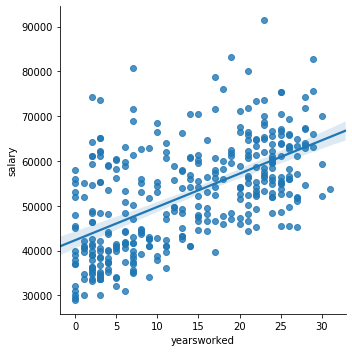

In [8]:
sns.lmplot(x='yearsworked',y='salary',data=train)

Looking at the distribution of the salaries in the scatter plot above, it is evident that generally as one works more years they tend to get an increase in their income. The relationship between the two variables isn't the strongest but we can definately see a positive correlation in the trend.

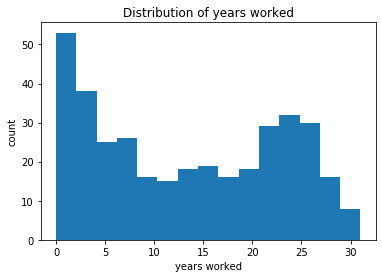

In [10]:
plt.hist(train.yearsworked, bins=15)
plt.title('Distribution of years worked')
plt.xlabel('years worked')
plt.ylabel('count')
plt.show()

The distribution of the number of years worked seems to be bimodal. This is seen by the two peaks on the left and right hand side of the histogram. A lot of the people have less than 5 years of work experience and the other peaking group has round about 25 years of work experience.

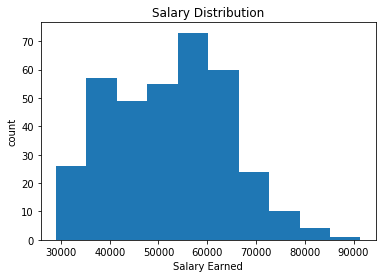

In [12]:
plt.hist(train.salary, bins=10)
plt.title('Salary Distribution')
plt.xlabel('Salary Earned')
plt.ylabel('count')
plt.show()

The salaries histogram is right-tailed. This is because most of the people earn around 65k and less, as opposed to the few who make north of 70k.

### outliers
Are there any outliers in my data?

<function matplotlib.pyplot.show(*args, **kw)>

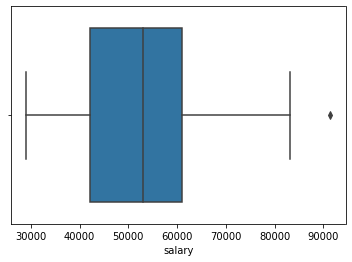

In [51]:
sns.boxplot(train.salary)
plt.show

The boxplot above shows that there is an outlier in my training data, which is earning north of 90k. This is really high compared to what everyone else is making. The median is seen to be somewhere over 50k.

Let us inspect the outlier, using the formula:

q3+ (1.5 * iqr);

where q3= 75th percentile
iqr= interquartile range (The range of the middle 50% of our data)

In [14]:
from scipy.stats import iqr
import numpy as np
my_iqr= iqr(train.salary)

q3= np.percentile(train.salary, 75)
upper_bound= q3+ 1.5 * my_iqr
train[train.salary>upper_bound]

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
280,91405.0,0,23,14,1.18,1,0,3,1,1,0


In [15]:
print(f'The interquartile range is {my_iqr}')

The interquartile range is 18920.0


The outlier in my data is an engineering executive male who earning 91405, has worked 23 years of which 14 of those were in that rank.

In [53]:
train=train.drop(280, axis=0)
train.shape

(358, 11)

I choose to drop my outlier, I will not lose a lot of data for my model.

###  Are the data appropriate for linear regression? Is there anything that needs to be transformed or edited first?

Looking at the data, we see that it is appropriate for linear regression.
From the scatter plot above we see that there is some form of linear relationship between our independent variable (years worked) and our dependent variable (salary).

## 2. Using the statsmodels package and the training data, run a simple linear regression for Salary with one predictor variable: Years Worked.

In [16]:
import statsmodels.formula.api as smf

model= smf.ols(formula= 'salary ~ yearsworked', data= train).fit()

I train a simple linear regressor using one feature which is years worked column in order to predict the salary of each person.

### making sense of the model coefficient

The average salary for someone with no experience is 42334.


### Does the model significantly predict the dependent variable?

In [21]:
preds= model.predict(train.yearsworked)

In [22]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     181.6
Date:                Mon, 10 Feb 2020   Prob (F-statistic):           9.52e-34
Time:                        14:27:48   Log-Likelihood:                -3801.4
No. Observations:                 359   AIC:                             7607.
Df Residuals:                     357   BIC:                             7614.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4.233e+04    897.607     47.164      0.000    4.06e+04    4.41e+04
yearsworked   742.4549     55.094     13.476      0.000     634.104     850.805
==============================================================================
Omnibus:                       31.186   Durbin-Watson:                   1.760
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.947
Skew:                           0.775   Prob(JB):                     9.48e-09
Kurtosis:                       3.262   Cond. No.                         28.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
#r-squared
r_squared= model.rsquared
#p values
pvals= model.pvalues

print(f'r^2 is {r_squared}')
print('-----------------------------------')
print(f'p vals are {pvals[0]}')

r^2 is 0.3371752031178994
-----------------------------------
p vals are 1.956450883536353e-155


(H0)  Null Hypothesis: There's no relationship between salary and years worked.

(H1) Alternative Hypothsis: There is a linear relationship between salary and years worked.

significance level= 0.05

our pvalue is far below our significance level and so the linear relationship between salaries and years worked cannot be due to random chance. Therefore our alternative hypothesis has proven to be true and we reject our null hypothesis.

### What percentage of the variance in employees’ salaries is accounted for by the number of years they have worked?

33.7% of the variance in employee salaries is accounted for by the number of years worked.

### 3. What does the unstandardized coefficient (B or ‘coef’ in statsmodels) tell you about the relationship between Years Worked and Salary?

In [24]:
model.params

Intercept      42334.665436
yearsworked      742.454869
dtype: float64

For every year worked, people get a salary increase of 742 a year.

## 4. What do the 95% confidence intervals [0.025, 0.975] mean?

In [25]:
model.conf_int()

,0,1
Intercept,40569.403506,44099.927366
yearsworked,634.104489,850.805249


It basically tells us that the true mean of the population (salaries in this case), will lie within +-2 standard deviations of our sample mean (this data set). Between 40640 and 44120. Only about 5% of of the times will it not.

## 5. Calculate the expected salary for someone with 12 years’ work experience.

In [26]:
X_12 = pd.DataFrame({'yearsworked': [12]})
y_12= model.predict(X_12)
print(f'someone who has worked 12 years will earn {y_12.iloc[0]}')

someone who has worked 12 years will earn 51244.12386466002


## 6. Calculate the expected salary for someone with 80 years’ work experience. Are there any problems with this prediction? If so, what are they?

In [27]:
X_80 = pd.DataFrame({'yearsworked': [80]})
y_80= model.predict(X_80)
print(f'someone who has worked 80 years will earn {y_80.iloc[0]}')

someone who has worked 80 years will earn 101731.05496240259


The problem with this model is that it assumes that people can work forever. Overtime there will be a diminishing returns on the productivity as people get older, so someone with 80 years of work experience is most likely to be retired.

### 7. We have only looked at the number of years an employee has worked. What other employee characteristics might influence their salary?

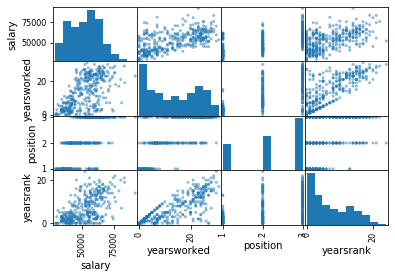

In [28]:
from pandas.plotting import scatter_matrix

scatter_matrix(train[['salary','yearsworked', 'position', 'yearsrank']])
plt.show()

Looking at the scatter matrix above, we can see in the salary row that there is a positive correlation between salary and years worked as well as yearsrank.

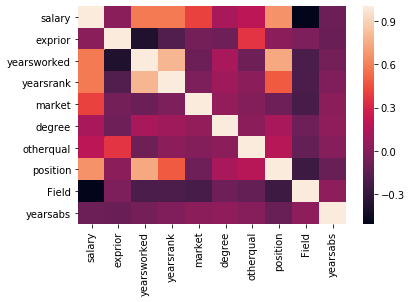

In [29]:
sns.heatmap(train.drop('male', axis=1).corr())

In [30]:
train.corr()['salary']

salary         1.000000
exprior        0.018516
yearsworked    0.580668
yearsrank      0.576945
market         0.406566
degree         0.120654
otherqual      0.194598
position       0.660481
male                NaN
Field         -0.504320
yearsabs      -0.092818
Name: salary, dtype: float64

Other interesting features to look at include;
1. position
2. yearsrank
3. market
4. Field

### Testset

In [31]:
from statsmodels.tools.eval_measures import rmse

test_preds= model.predict(test.yearsworked)

In [32]:
rmse_train= rmse(train.salary, preds)
rmse_test= rmse(test.salary, test_preds)
print(f'The rmse  for the train set is {rmse_train}')
print(f'The rmse  for the test set is {rmse_test}')
print(f'the difference in RMSE between training and testing is {rmse_test- rmse_train}')

The rmse  for the train set is 9602.837216867694
The rmse  for the test set is 10836.807670089815
the difference in RMSE between training and testing is 1233.9704532221203


Our model performs better on our training set than on our test set. This means that our model is slightly overfitting. Adding more training examples may help our model to perform better. Another option would be to consider adding other features to our model or just looking at other kinds of models such as Logistic Regressors.

## Conclusion

After having analyzed the employee salaries data above, I have found that there is a positive correlation between years worked and the salary earned. This is a suitable relationship for a linear regression.

However, I also found that there is a better predictor which is the position a person works. In the appendix below, I train a model based on the position feature only and it performs better, as it's seen by a lower error.

## Appednix A

In [30]:
model_pos =smf.ols(formula= 'salary ~ position', data= train).fit()
preds= model_pos.predict(train.position)
model_pos.rsquared

0.43623535866185525

This means that roughly 43.6% of the salary increase can be accounted for by the position one is working. The other 56.4% would be from other variables.

In [31]:
pos_preds = model_pos.predict(test.position)
rmse_pos= rmse(test.salary, pos_preds)
rmse_pos

9575.727663943804

We have an error of 9575, which is slightly better compared to the 9602 which we found in the model trained from only the years worked feature.